In [ ]:
import numpy as np
import skimage

def apply_region_mask(frame):
    """Applies a region-based mask to a given foreground mask."""
    
    vertices1 = np.array([[160, 900], [220, 70], [1090, 140], [1045, 945]])  # Keep
    vertices2 = np.array([[150, 180], [170, 40], [535, 40], [525, 190]])  # Remove
    
    # Ensure mask has correct shape
    frame_shape = frame.shape

    # Create a mask for the region to keep
    mask1 = np.zeros(frame_shape, dtype=bool)
    rr1, cc1 = skimage.draw.polygon(vertices1[:, 1], vertices1[:, 0], mask1.shape)  # Swap x and y
    mask1[rr1, cc1] = True

    # Create a mask for the region to remove
    mask2 = np.zeros(frame_shape, dtype=bool)
    rr2, cc2 = skimage.draw.polygon(vertices2[:, 1], vertices2[:, 0], mask2.shape)  # Swap x and y
    mask2[rr2, cc2] = True

    # Create the final mask: Keep region inside vertices1, remove region inside vertices2
    final_mask = np.logical_and(mask1, ~mask2)

    # Apply the final mask to the foreground mask
    filtered_frame = np.logical_and(frame, final_mask)

    return filtered_frame

In [1]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from skimage import io, morphology, filters
from skimage.transform import resize

def get_foreground_mask(background_path, video_path, frame_index=100, threshold=0.15, apply_gaussian=False, sigma=2):
    """Compute the foreground mask by comparing the frame with the background image."""
    # Load background and remove alpha channel if present
    background = io.imread(background_path) / 255
    if background.shape[-1] == 4:  # RGBA Image
        background = background[..., :3]  # Keep only RGB channels
    
    background = skimage.color.rgb2hsv(background)

    # Load frame from video or image
    with_subjects = iio.imread(video_path, index=frame_index)
    
    # Convert frame to HSV
    with_subjects_hsv = skimage.color.rgb2hsv(with_subjects)

    # Apply Gaussian blur to background and frame if enabled
    if apply_gaussian:
        background = filters.gaussian(background, sigma=sigma, channel_axis=-1)
        with_subjects_hsv = filters.gaussian(with_subjects_hsv, sigma=sigma, channel_axis=-1)

    # Compute mean squared difference across channels
    diff = np.sqrt(((with_subjects_hsv - background) ** 2)).mean(axis=2)

    # Compute foreground mask
    foreground_mask = diff >= threshold

    return foreground_mask

# Paths to background images
background3_path = "background3.png"
background4_path = "background4.png"

# Path to video frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get foreground masks for both backgrounds
foreground_mask_3 = get_foreground_mask(background3_path, video_path, threshold=0.15)
foreground_mask_4 = get_foreground_mask(background4_path, video_path, threshold=0.15)

# Merge both masks using logical OR
merged_foreground_mask = apply_region_mask(np.logical_or(foreground_mask_3, foreground_mask_4))

# Display results
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(foreground_mask_3, cmap='gray')
ax[0].set_title("Foreground Mask - Background 3")

ax[1].imshow(foreground_mask_4, cmap='gray')
ax[1].set_title("Foreground Mask - Background 4")

ax[2].imshow(merged_foreground_mask, cmap='gray')
ax[2].set_title("Merged Foreground Mask")

ax[3].imshow(io.imread(video_path, index=100))
ax[3].set_title("Original Frame")

plt.show()


NameError: name 'apply_region_mask' is not defined

/tmp/ipykernel_1358417/1995926737.py:60: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  ax[3].imshow(io.imread(video_path, index=100))


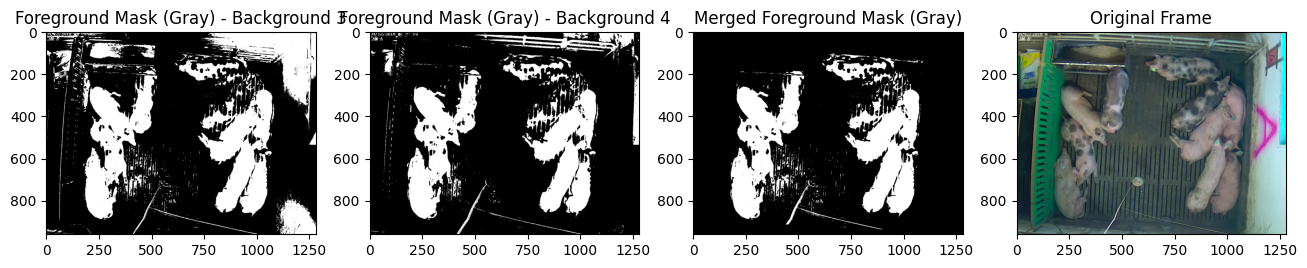

In [ ]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, morphology

def get_foreground_mask_gray(background_path, video_path, frame_index=100, threshold=0.15, apply_gaussian=False, sigma=2):
    """Compute the foreground mask by comparing the grayscale frame with the background image."""
    # Load background and convert to grayscale
    background = io.imread(background_path) / 255
    if background.shape[-1] == 4:  # Remove alpha channel if present
        background = background[..., :3]
    background_gray = color.rgb2gray(background)

    # Load frame
    with_subjects = iio.imread(video_path, index=frame_index)

    # Convert frame to grayscale
    with_subjects_gray = color.rgb2gray(with_subjects)
    
    # Apply Gaussian blur to background and frame if enabled
    if apply_gaussian:
        background = filters.gaussian(background, sigma=sigma)
        with_subjects_gray = filters.gaussian(with_subjects_gray, sigma=sigma)


    # Compute absolute difference
    diff = np.abs(with_subjects_gray - background_gray)

    # Compute foreground mask
    foreground_mask = diff >= threshold

    return foreground_mask

# Paths to background images
background3_path = "background3.png"
background4_path = "background4.png"

# Path to video frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get grayscale foreground masks for both backgrounds
foreground_mask_gray_3 = get_foreground_mask_gray(background3_path, video_path)
foreground_mask_gray_4 = get_foreground_mask_gray(background4_path, video_path)

# Merge both grayscale masks using logical OR
merged_foreground_mask_gray = apply_region_mask(np.logical_or(foreground_mask_gray_3, foreground_mask_gray_4))

# Display results
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(foreground_mask_gray_3, cmap='gray')
ax[0].set_title("Foreground Mask (Gray) - Background 3")

ax[1].imshow(foreground_mask_gray_4, cmap='gray')
ax[1].set_title("Foreground Mask (Gray) - Background 4")

ax[2].imshow(merged_foreground_mask_gray, cmap='gray')
ax[2].set_title("Merged Foreground Mask (Gray)")

ax[3].imshow(io.imread(video_path, index=100))
ax[3].set_title("Original Frame")

plt.show()


/tmp/ipykernel_1358417/1778475395.py:65: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  ax[4].imshow(io.imread(video_path, index=100))


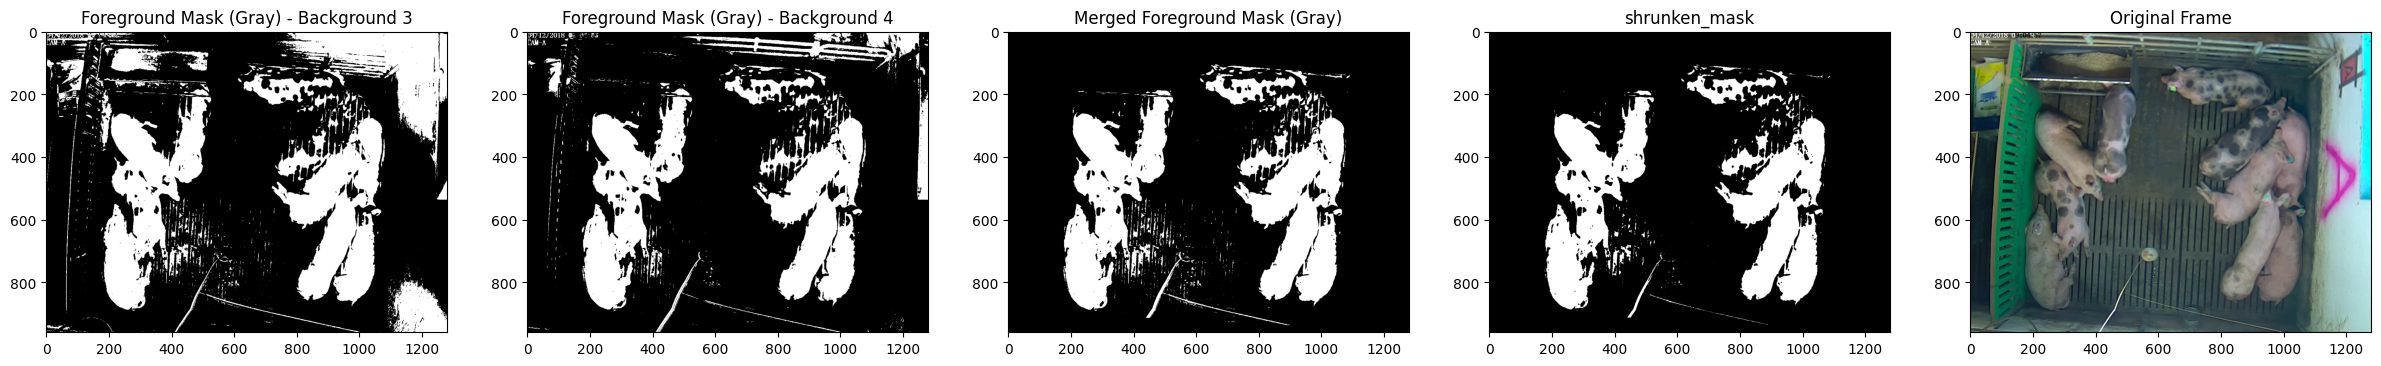

In [ ]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, morphology

def get_foreground_mask_gray(background_path, video_path, frame_index=100, threshold=0.15, apply_gaussian=False, sigma=2):
    """Compute the foreground mask by comparing the grayscale frame with the background image."""
    # Load background and convert to grayscale
    background = io.imread(background_path) / 255
    if background.shape[-1] == 4:  # Remove alpha channel if present
        background = background[..., :3]
    background_gray = color.rgb2gray(background)

    # Load frame
    with_subjects = iio.imread(video_path, index=frame_index)

    # Convert frame to grayscale
    with_subjects_gray = color.rgb2gray(with_subjects)
    
    # Apply Gaussian blur to background and frame if enabled
    if apply_gaussian:
        background = filters.gaussian(background, sigma=sigma)
        with_subjects_gray = filters.gaussian(with_subjects_gray, sigma=sigma)


    # Compute absolute difference
    diff = np.abs(with_subjects_gray - background_gray)

    # Compute foreground mask
    foreground_mask = diff >= threshold

    return foreground_mask

# Paths to background images
background3_path = "background3.png"
background4_path = "background4.png"

# Path to video frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get grayscale foreground masks for both backgrounds
foreground_mask_gray_3 = get_foreground_mask_gray(background3_path, video_path)
foreground_mask_gray_4 = get_foreground_mask_gray(background4_path, video_path)

# Merge both grayscale masks using logical OR
merged_foreground_mask_gray = apply_region_mask(np.logical_or(foreground_mask_gray_3, foreground_mask_gray_4))

shrunken_mask = morphology.erosion(merged_foreground_mask_gray, morphology.disk(1))

# Display results
fig, ax = plt.subplots(1, 5, figsize=(30, 15))
ax[0].imshow(foreground_mask_gray_3, cmap='gray')
ax[0].set_title("Foreground Mask (Gray) - Background 3")

ax[1].imshow(foreground_mask_gray_4, cmap='gray')
ax[1].set_title("Foreground Mask (Gray) - Background 4")

ax[2].imshow(merged_foreground_mask_gray, cmap='gray')
ax[2].set_title("Merged Foreground Mask (Gray)")

ax[3].imshow(shrunken_mask, cmap='gray')
ax[3].set_title("shrunken_mask")

ax[4].imshow(io.imread(video_path, index=100))
ax[4].set_title("Original Frame")

plt.show()

/tmp/ipykernel_1358417/3872619407.py:37: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  ax[3].imshow(io.imread(video_path, index=100))


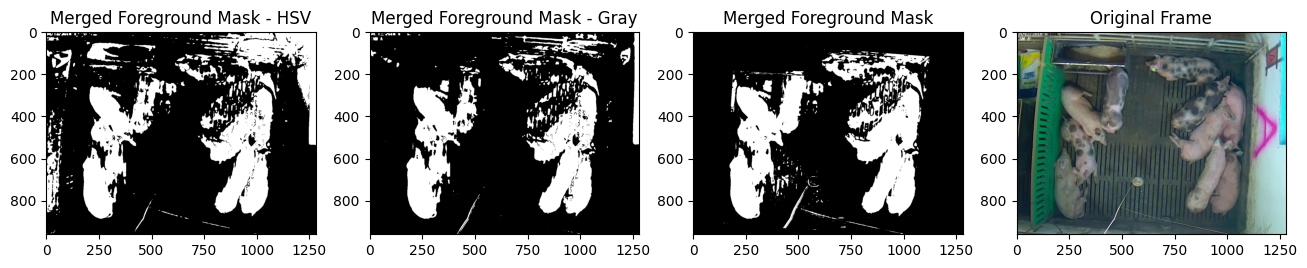

In [ ]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from skimage import io, morphology
from skimage.transform import resize

# Paths to background images
background3_path = "background3.png"
background4_path = "background4.png"

# Path to video frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get foreground masks for both backgrounds
foreground_mask_3 = get_foreground_mask(background3_path, video_path, threshold=0.15, apply_gaussian=True, sigma=2)
foreground_mask_4 = get_foreground_mask(background4_path, video_path, threshold=0.15, apply_gaussian=True, sigma=2)
foreground_mask_gray_3 = get_foreground_mask_gray(background3_path, video_path, apply_gaussian=True, sigma=2)
foreground_mask_gray_4 = get_foreground_mask_gray(background4_path, video_path, apply_gaussian=True, sigma=2)

# Merge both masks using logical OR
merged_foreground_mask_hsv = np.logical_or(foreground_mask_3, foreground_mask_4)
merged_foreground_mask_gray = np.logical_or(foreground_mask_gray_3, foreground_mask_gray_4)
merged_foreground_mask = apply_region_mask(np.logical_or(merged_foreground_mask_hsv, merged_foreground_mask_gray))

# Display results
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(foreground_mask_3, cmap='gray')
ax[0].set_title("Merged Foreground Mask - HSV")

ax[1].imshow(foreground_mask_4, cmap='gray')
ax[1].set_title("Merged Foreground Mask - Gray")

ax[2].imshow(merged_foreground_mask, cmap='gray')
ax[2].set_title("Merged Foreground Mask")

ax[3].imshow(io.imread(video_path, index=100))
ax[3].set_title("Original Frame")

plt.show()

/tmp/ipykernel_1358417/1671796939.py:42: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  ax[4].imshow(io.imread(video_path, index=100))


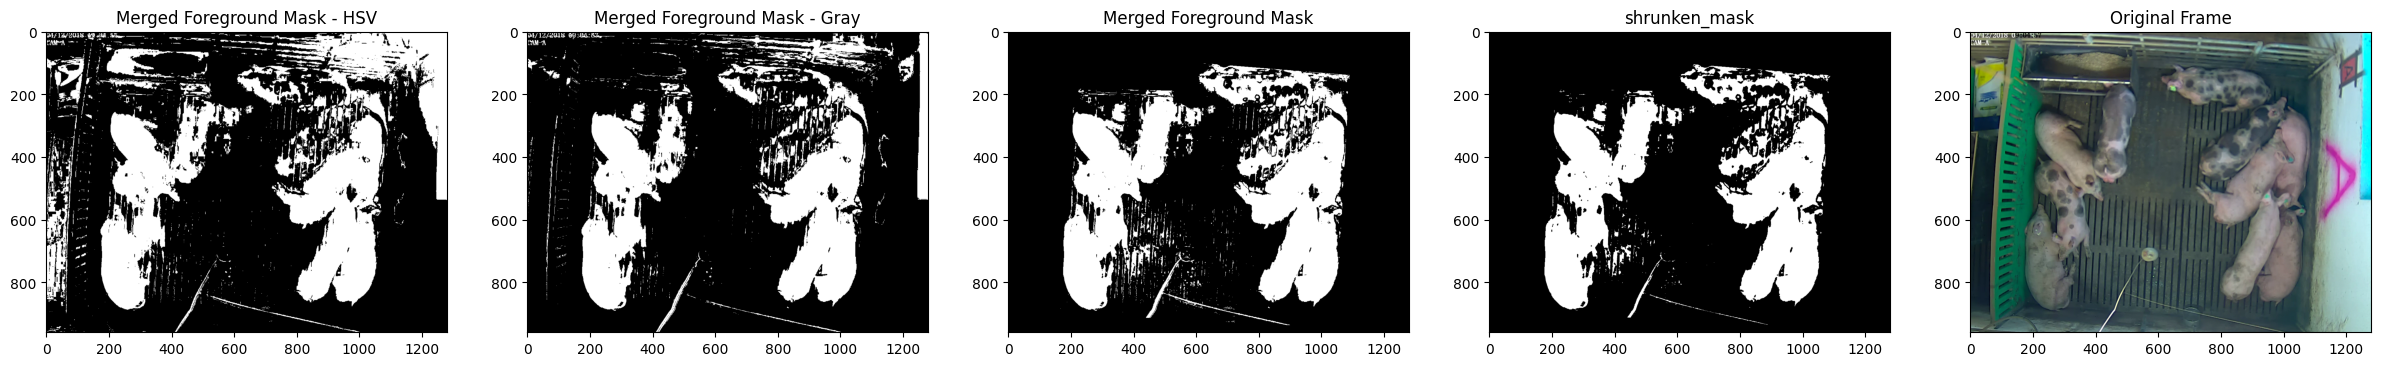

In [ ]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from skimage import io, morphology
from skimage.transform import resize

# Paths to background images
background3_path = "background3.png"
background4_path = "background4.png"

# Path to video frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get foreground masks for both backgrounds
foreground_mask_3 = get_foreground_mask(background3_path, video_path, threshold=0.15)
foreground_mask_4 = get_foreground_mask(background4_path, video_path, threshold=0.15)
foreground_mask_gray_3 = get_foreground_mask_gray(background3_path, video_path)
foreground_mask_gray_4 = get_foreground_mask_gray(background4_path, video_path)

# Merge both masks using logical OR
merged_foreground_mask_hsv = np.logical_or(foreground_mask_3, foreground_mask_4)
merged_foreground_mask_gray = np.logical_or(foreground_mask_gray_3, foreground_mask_gray_4)
merged_foreground_mask = apply_region_mask(np.logical_or(merged_foreground_mask_hsv, merged_foreground_mask_gray))

shrunken_mask = morphology.erosion(merged_foreground_mask, morphology.disk(1))

# Display results
fig, ax = plt.subplots(1, 5, figsize=(30, 20))
ax[0].imshow(foreground_mask_3, cmap='gray')
ax[0].set_title("Merged Foreground Mask - HSV")

ax[1].imshow(foreground_mask_4, cmap='gray')
ax[1].set_title("Merged Foreground Mask - Gray")

ax[2].imshow(merged_foreground_mask, cmap='gray')
ax[2].set_title("Merged Foreground Mask")

ax[3].imshow(shrunken_mask, cmap='gray')
ax[3].set_title("shrunken_mask")

ax[4].imshow(io.imread(video_path, index=100))
ax[4].set_title("Original Frame")

plt.show()


/tmp/ipykernel_1358417/1249640452.py:102: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  ax[3].imshow(io.imread(video_path, index=100), cmap='gray')


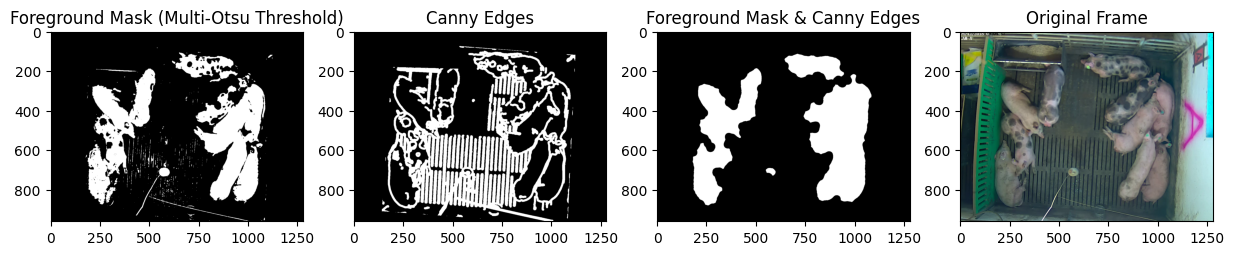

In [ ]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure
from scipy.ndimage import binary_fill_holes

def get_foreground_mask_multiotsu(video_path, frame_index=100):
    """Compute the foreground mask by using Multi-Otsu thresholding after converting the frame to grayscale."""
    
    # Load frame from video or image
    with_subjects = iio.imread(video_path, index=frame_index)
    
    # Convert the frame to grayscale
    with_subjects_gray = color.rgb2gray(with_subjects)

    # Apply Multi-Otsu thresholding to the grayscale image
    thresholds = filters.threshold_multiotsu(with_subjects_gray, classes=5)  # Using 3 classes for segmentation

    # Create a mask for the foreground using the first threshold
    mask = with_subjects_gray > thresholds[1]  # Choose the second threshold for foreground (may need tuning)

    return mask

def get_canny_edges(video_path, frame_index=100, low_threshold=0.08, high_threshold=0.3, thickness=3):
    # Load frame from video or image
    frame = iio.imread(video_path, index=frame_index)
    
    frame_gray = color.rgb2gray(frame)
    
    edges = skimage.feature.canny(frame_gray, low_threshold=low_threshold, high_threshold=high_threshold)
    
    # Make edges thicker using dilation
    thick_edges = morphology.dilation(edges, morphology.disk(thickness))

    return thick_edges

def remove_small_objects_from_mask(foreground_mask, min_size=200):
    """Remove small connected components (subjects) from the foreground mask."""
    
    # Ensure the mask is boolean
    foreground_mask = foreground_mask.astype(bool)

    # Remove small objects
    cleaned_mask = morphology.remove_small_objects(foreground_mask, min_size=min_size)

    return cleaned_mask

def remove_big_objects_from_mask(foreground_mask, max_size=87000):
    """Remove big connected components (subjects) from the foreground mask."""
    # Ensure the mask is boolean
    foreground_mask = foreground_mask.astype(bool)

    # Label connected components
    labeled_mask = measure.label(foreground_mask)

    # Get region properties
    for region in measure.regionprops(labeled_mask):
        print(region.area)
        if region.area > max_size:
            labeled_mask[labeled_mask == region.label] = 0  # Remove large objects

    # Convert back to binary mask
    cleaned_mask = labeled_mask > 0

    return cleaned_mask

def fill_missing_parts(mask, closing_size=20, dilation_size=5):
    """Fill missing parts of the objects (pigs) by closing gaps and filling holes."""
    # Apply dilation first to expand object regions
    dilated_mask = morphology.dilation(mask, morphology.disk(dilation_size))

    # Apply morphological closing to close large gaps
    closed_mask = morphology.closing(dilated_mask, morphology.disk(closing_size))

    # Fill holes inside objects
    filled_mask = binary_fill_holes(closed_mask)

    return filled_mask

# Paths to frame
video_path = "/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14/1_Manual Record_2018-12-04 09-04-54_2018-12-04 09-17-31.mp4"

# Get foreground mask using Multi-Otsu thresholding
foreground_mask = apply_region_mask(get_foreground_mask_multiotsu(video_path))

edges = apply_region_mask(get_canny_edges(video_path, thickness=5))

filled_missing_parts = fill_missing_parts(foreground_mask_edges)

# Display results
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(foreground_mask, cmap='gray')
ax[0].set_title("Foreground Mask (Multi-Otsu Threshold)")

ax[1].imshow(edges, cmap='gray')
ax[1].set_title("Canny Edges")

ax[2].imshow(filled_missing_parts, cmap='gray')
ax[2].set_title("Foreground Mask")

ax[3].imshow(io.imread(video_path, index=100), cmap='gray')
ax[3].set_title("Original Frame")

plt.show()


[39858.5, 23268.0, 19256.0, 18249.0, 18064.0, 15911.5, 9248.5, 8041.5, 5919.0, 5182.5, 3355.5, 695.0, 378.0, 275.5, 201.5, 188.5]
[39858.5, 23642.5, 23268.0, 19256.0, 18353.0, 15911.5, 9798.5, 9332.5, 9248.5, 378.0, 201.5]


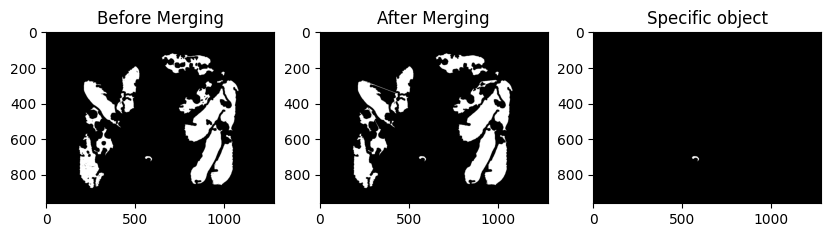

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import cv2
import numpy as np

def merge_close_objects(foreground_mask_edges, max_area=16000, max_distance=80):
    contours, _ = cv2.findContours((foreground_mask_edges * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    objects = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            objects.append((cnt, (cx, cy), area))
    
    merged_contours = []
    merged = set()
    
    for i, (cnt1, (x1, y1), area1) in enumerate(objects):
        if i in merged:
            continue
        
        new_contour = cnt1.copy()
        total_area = area1
        merged.add(i)
        
        for j, (cnt2, (x2, y2), area2) in enumerate(objects):
            if j in merged or i == j:
                continue
            
            dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if dist < max_distance and (total_area + area2) <= max_area:
                new_contour = np.vstack((new_contour, cnt2))
                total_area += area2
                merged.add(j)
                
        merged_contours.append(new_contour)
    
    # Create a new mask and draw merged contours
    merged_mask = np.zeros_like(foreground_mask_edges, dtype=np.uint8)
    cv2.drawContours(merged_mask, merged_contours, -1, 255, thickness=cv2.FILLED)

    return merged_mask

foreground_mask_edges = remove_small_objects_from_mask(np.logical_and(foreground_mask, ~edges))

# Apply function
merged_mask = merge_close_objects(foreground_mask_edges, max_area=25000, max_distance=200)

contours, _ = cv2.findContours((foreground_mask_edges * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(sorted([cv2.contourArea(cnt) for cnt in contours], reverse=True))
contours, _ = cv2.findContours((merged_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(sorted([cv2.contourArea(cnt) for cnt in contours], reverse=True))

def keep_specific_size_objects(mask, target_size=378.0):
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    specific_contours = [cnt for cnt in contours if cv2.contourArea(cnt) == target_size]
    
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.drawContours(filtered_mask, specific_contours, -1, 255, thickness=cv2.FILLED)
    
    return filtered_mask

specific_object = keep_specific_size_objects(foreground_mask_edges, target_size=378.0)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(foreground_mask_edges, cmap='gray')
ax[0].set_title("Before Merging")

ax[1].imshow(merged_mask, cmap='gray')
ax[1].set_title("After Merging")

ax[2].imshow(specific_object, cmap='gray')
ax[2].set_title("Specific object")

plt.show()


[39858.5, 23268.0, 19256.0, 18249.0, 18064.0, 15911.5, 9248.5, 8041.5, 5919.0, 5182.5, 3355.5, 695.0, 378.0, 275.5, 201.5, 188.5]
[39858.5, 23268.0, 19256.0, 18353.0, 18249.0, 15911.5, 14391.5, 10916.0, 9332.5, 378.0]


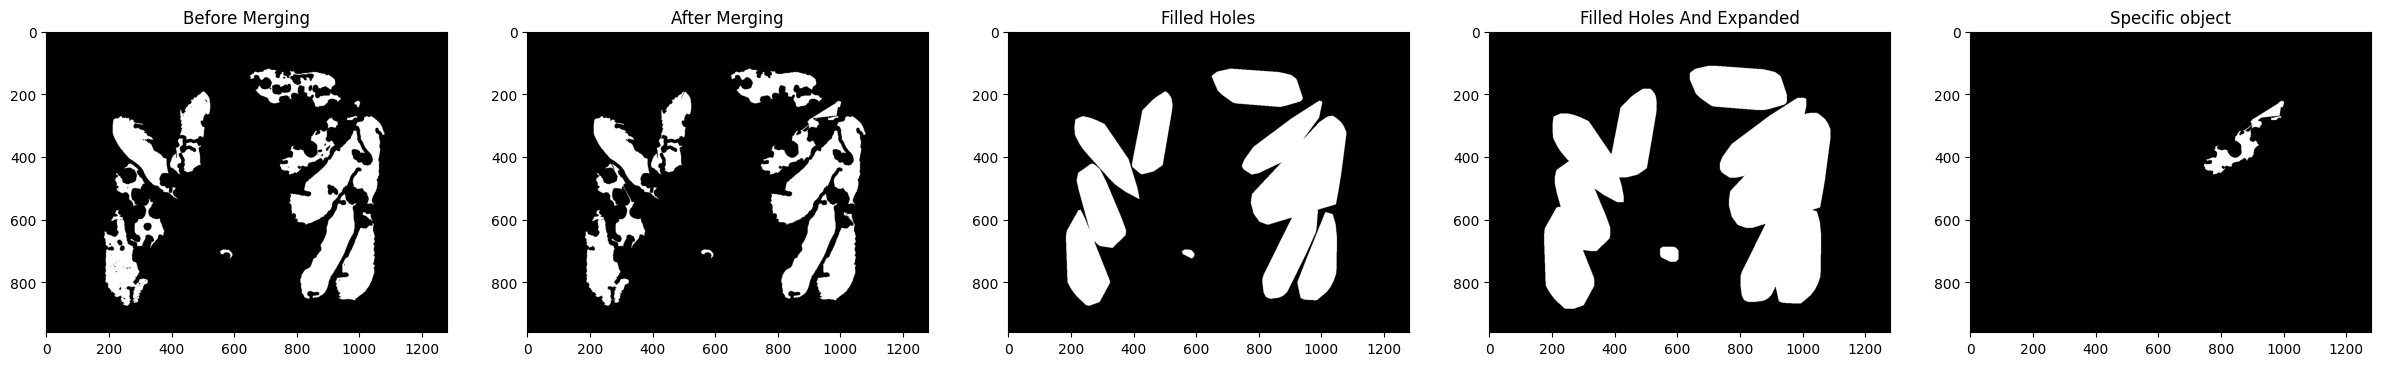

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import cv2
import numpy as np

def merge_close_objects(foreground_mask_edges, max_area=16000, max_distance=80):
    contours, _ = cv2.findContours((foreground_mask_edges * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    objects = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            objects.append((cnt, (cx, cy), area))
    
    merged_contours = []
    merged = set()
    
    objects.sort(key=lambda x: x[2])  # Sort objects by area (smallest first)
    
    for i, (cnt1, (x1, y1), area1) in enumerate(objects):
        if i in merged:
            continue
        
        new_contour = cnt1.copy()
        total_area = area1
        merged.add(i)
        
        for j, (cnt2, (x2, y2), area2) in enumerate(objects[i+1:]):
            idx = i + 1 + j
            if idx in merged:
                continue
            
            dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if dist < max_distance and (total_area + area2) <= max_area:
                new_contour = np.vstack((new_contour, cnt2))
                total_area += area2
                merged.add(idx)
                
        merged_contours.append(new_contour)
    
    # Create a new mask and draw merged contours
    merged_mask = np.zeros_like(foreground_mask_edges, dtype=np.uint8)
    cv2.drawContours(merged_mask, merged_contours, -1, 255, thickness=cv2.FILLED)

    return merged_mask

def fill_holes(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(mask, dtype=np.uint8)
    
    for cnt in contours:
        hull = cv2.convexHull(cnt)
        cv2.drawContours(filled_mask, [hull], -1, 255, thickness=cv2.FILLED)
    
    return filled_mask

def fill_holes_and_expand(mask, dilation_thickness=5):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a filled mask
    filled_mask = np.zeros_like(mask, dtype=np.uint8)
    
    # Draw filled contours (convex hulls)
    for cnt in contours:
        hull = cv2.convexHull(cnt)
        cv2.drawContours(filled_mask, [hull], -1, 255, thickness=cv2.FILLED)
    
    # Perform dilation to expand the objects
    kernel = np.ones((dilation_thickness, dilation_thickness), np.uint8)
    expanded_mask = cv2.dilate(filled_mask, kernel, iterations=1)
    
    return expanded_mask

# Apply function
merged_mask = merge_close_objects(merge_close_objects(foreground_mask_edges, max_area=24000, max_distance=150), max_area=24000, max_distance=200)

filled_holes = fill_holes(merged_mask)
filled_and_expanded_holes = fill_holes_and_expand(merged_mask, dilation_thickness=20)

contours, _ = cv2.findContours((foreground_mask_edges * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(sorted([cv2.contourArea(cnt) for cnt in contours], reverse=True))
contours, _ = cv2.findContours((merged_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(sorted([cv2.contourArea(cnt) for cnt in contours], reverse=True))

def keep_specific_size_objects(mask, target_size=378.0):
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    specific_contours = [cnt for cnt in contours if cv2.contourArea(cnt) == target_size]
    
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.drawContours(filtered_mask, specific_contours, -1, 255, thickness=cv2.FILLED)
    
    return filtered_mask

specific_object = keep_specific_size_objects(merged_mask, target_size=10916.0)

# Display results
fig, ax = plt.subplots(1, 5, figsize=(30, 15))
ax[0].imshow(foreground_mask_edges, cmap='gray')
ax[0].set_title("Before Merging")

ax[1].imshow(merged_mask, cmap='gray')
ax[1].set_title("After Merging")

ax[2].imshow(filled_holes, cmap='gray')
ax[2].set_title("Filled Holes")

ax[3].imshow(filled_and_expanded_holes, cmap='gray')
ax[3].set_title("Filled Holes And Expanded")

ax[4].imshow(specific_object, cmap='gray')
ax[4].set_title("Specific object")

plt.show()
